In [1]:
using GPFlux
using Distributions
using Random
using PyPlot
using LinearAlgebra

Random.seed!(4);

┌ Info: CUDAdrv.jl failed to initialize, GPU functionality unavailable (set JULIA_CUDA_SILENT or JULIA_CUDA_VERBOSE to silence or expand this message)
└ @ CUDAdrv /Users/hongbinren/.julia/packages/CUDAdrv/mCr0O/src/CUDAdrv.jl:69


In [2]:
# plot samples
function gprior_plot(samples::NTuple{3, AbstractArray})
    fig, axes = subplots(1, 3)
    for i in eachindex(axes)
        for j in 1:5
            axes[i].plot(reshape(X1d, 100), samples[i][:, j])
        end
    end
end

gprior_plot (generic function with 1 method)

In [3]:
isorbf_kernel = IsoGaussKernel([exp(0.5)], [exp(0.0)])
isoperiod_kernel = IsoPeriodKernel([exp(1.0)], [exp(0.5)], [exp(0.0)])
isolinear_kernel = IsoLinearKernel([1.0])

#check PSD
X = rand(4, 10)
@show isposdef(isorbf_kernel(X))
@show isposdef(isoperiod_kernel(X))
@show isposdef(isolinear_kernel(X))

isposdef(isorbf_kernel(X)) = true
isposdef(isoperiod_kernel(X)) = true
isposdef(isolinear_kernel(X)) = true


true

In [4]:
# Gauss process with zero mean
zero_mean = ConstantMean([0.0])
noise = [0.0]

isorbf_gp = GaussProcess(zero_mean, isorbf_kernel, noise)
isoperiod_gp = GaussProcess(zero_mean, isoperiod_kernel, noise)
isolinear_gp = GaussProcess(zero_mean, isolinear_kernel, noise)

GaussProcess{ConstantMean{Float64},IsoLinearKernel{Float64,Array{Float64,1}},Array{Float64,1}}(ConstantMean{Float64}([0.0]), IsoLinearKernel{Float64,Array{Float64,1}}([1.0]), [0.0])

In [5]:
# sample from different GP prior
X1d = reshape(Array(range(-5.0, 5.0, length=100)), 1, 100)
isorbf_d = MvNormal(isorbf_gp, X1d)
isoperiod_d = MvNormal(isoperiod_gp, X1d)
isolinear_d = MvNormal(isolinear_gp, X1d)

se_samples = rand(isorbf_d, 5)
period_samples = rand(isoperiod_d, 5)
linear_samples = rand(isolinear_d, 5);

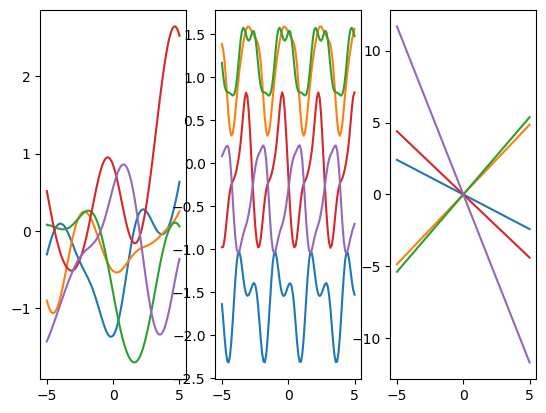

In [6]:
gprior_plot((se_samples, period_samples, linear_samples))

In [7]:
# composite kernels
period_lin_kernel = Period_mul_LinKernel((isoperiod_kernel, isolinear_kernel))
se_lin_kernel = SE_mul_LinKernel((isorbf_kernel, isolinear_kernel))
se_period_kernel = SE_mul_PeriodKernel((isorbf_kernel, isoperiod_kernel))

se_add_period_kernel = SE_add_PeriodKernel((isorbf_kernel, isoperiod_kernel))
seper_add_selin_kernel = AddCompositeKernel((se_period_kernel, se_lin_kernel))

#check PSD
X = rand(4, 10)
@show isposdef(period_lin_kernel(X))
@show isposdef(se_lin_kernel(X))
@show isposdef(se_period_kernel(X))
@show isposdef(se_add_period_kernel(X))
@show isposdef(seper_add_selin_kernel(X))

isposdef(period_lin_kernel(X)) = true
isposdef(se_lin_kernel(X)) = true
isposdef(se_period_kernel(X)) = true
isposdef(se_add_period_kernel(X)) = true
isposdef(seper_add_selin_kernel(X)) = true


true

In [8]:
perlin_gp = GaussProcess(zero_mean, period_lin_kernel, noise)
seaddper_gp = GaussProcess(zero_mean, se_add_period_kernel, noise)
seperaddselin_gp = GaussProcess(zero_mean, seper_add_selin_kernel, noise)

GaussProcess{ConstantMean{Float64},AddCompositeKernel{Tuple{ProductCompositeKernel{Tuple{IsoGaussKernel,IsoPeriodKernel}},ProductCompositeKernel{Tuple{IsoGaussKernel,IsoLinearKernel}}}},Array{Float64,1}}(ConstantMean{Float64}([0.0]), AddCompositeKernel{Tuple{ProductCompositeKernel{Tuple{IsoGaussKernel,IsoPeriodKernel}},ProductCompositeKernel{Tuple{IsoGaussKernel,IsoLinearKernel}}}}((ProductCompositeKernel{Tuple{IsoGaussKernel,IsoPeriodKernel}}((IsoGaussKernel{Float64,Array{Float64,1}}([1.6487212707001282], [1.0]), IsoPeriodKernel{Float64,Array{Float64,1}}([2.718281828459045], [1.6487212707001282], [1.0]))), ProductCompositeKernel{Tuple{IsoGaussKernel,IsoLinearKernel}}((IsoGaussKernel{Float64,Array{Float64,1}}([1.6487212707001282], [1.0]), IsoLinearKernel{Float64,Array{Float64,1}}([1.0]))))), [0.0])

In [9]:
DiffGP.params(seperaddselin_gp)

Params([[0.0], [1.6487212707001282], [1.0], [2.718281828459045], [1.6487212707001282], [1.0], [1.0], [0.0]])

In [11]:
# sample from composite GP prior
perlin_d = MvNormal(perlin_gp, X1d)
seaddper_d = MvNormal(seaddper_gp, X1d)
seperaddselin_d = MvNormal(seperaddselin_gp, X1d)

perlin_samples = rand(perlin_d, 5)
seaddper_samples = rand(seaddper_d, 5)
seperaddselin_samples = rand(seperaddselin_d, 5);

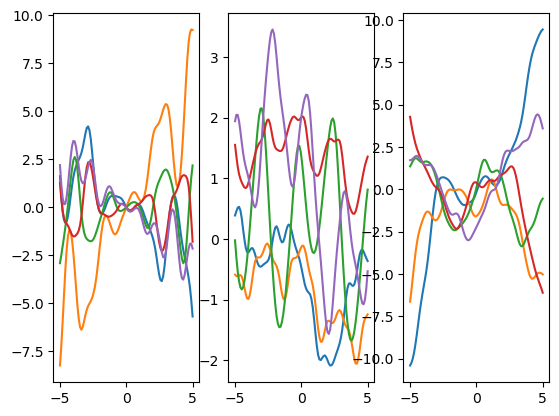

In [12]:
gprior_plot((perlin_samples, seaddper_samples, seperaddselin_samples))